<a href="https://colab.research.google.com/github/Ritupriya17/Frozen-Lake/blob/main/RL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

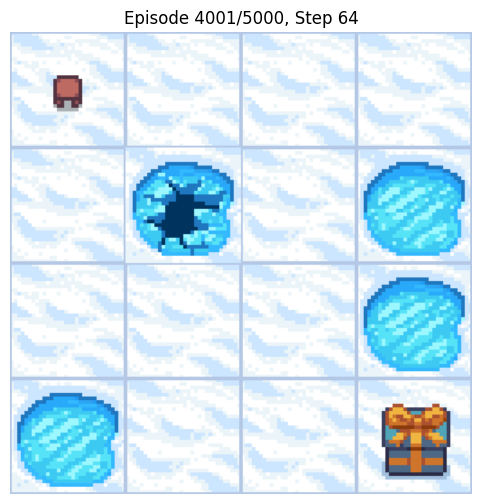

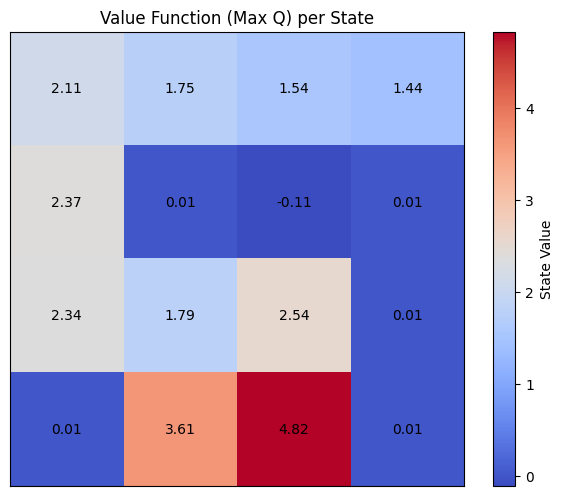

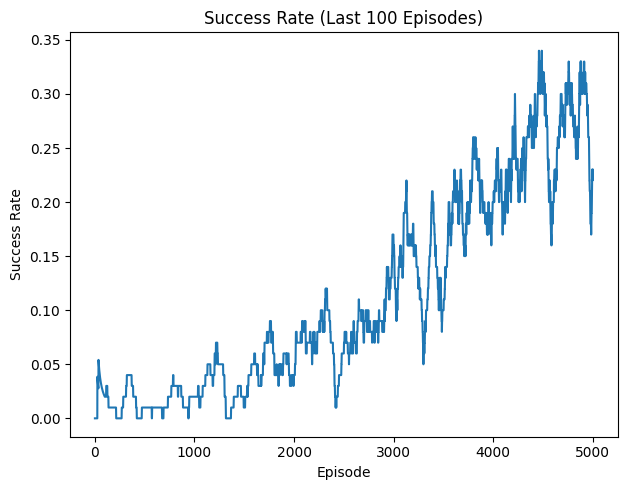


Final Evaluation of trained policy...
Final success rate over 1000 evaluation episodes: 69.40%


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from IPython.display import display, clear_output

def run(episodes, is_training=True, render=True, render_frequency=1):
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True,
                   render_mode='rgb_array' if render else None)

    if is_training:
        q = np.random.uniform(low=0, high=0.01, size=(env.observation_space.n, env.action_space.n))
    else:
        with open('frozen_lake4x4.pkl', 'rb') as f:
            q = pickle.load(f)

    learning_rate_a = 0.8
    discount_factor_g = 0.99
    epsilon = 1.0
    epsilon_decay_rate = 0.9995
    epsilon_min = 0.01
    learning_rate_decay = 0.9999
    min_learning_rate = 0.1

    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)
    cumulative_rewards = []
    success_rates = []

    if render:
        plt.figure(figsize=(6, 6))

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False
        episode_reward = 0
        steps = 0

        while not terminated and not truncated:
            steps += 1

            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                noise = np.random.random(env.action_space.n) * 0.01
                action = np.argmax(q[state, :] + noise)

            new_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            if is_training:
                best_next_action = np.argmax(q[new_state, :])
                adjusted_reward = reward

                if terminated and reward > 0:
                    adjusted_reward = 5.0
                elif terminated and reward == 0:
                    q[state, action] -= 0.5

                q[state, action] = q[state, action] + learning_rate_a * (
                    adjusted_reward + discount_factor_g * q[new_state, best_next_action] - q[state, action]
                )

            if render and is_training and (i % render_frequency == 0):
                img = env.render()
                plt.clf()
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Episode {i+1}/{episodes}, Step {steps}")
                display(plt.gcf())
                clear_output(wait=True)
                time.sleep(0.1)

            state = new_state
            if steps > 100:
                truncated = True

        rewards_per_episode[i] = episode_reward
        epsilon = max(epsilon * epsilon_decay_rate, epsilon_min)
        learning_rate_a = max(learning_rate_a * learning_rate_decay, min_learning_rate)

        window = min(100, i+1)
        cumulative_rewards.append(np.mean(rewards_per_episode[max(0, i-window+1):(i+1)]))
        success_rates.append(np.mean(rewards_per_episode[max(0, i-window+1):(i+1)]))

        if is_training and (i+1) == 1000:
            interim_success = evaluate_policy(q, 1000)
            print(f"\nInterim Evaluation after 1000 episodes: {interim_success:.2%} success rate\n")

    env.close()

    if is_training:
        with open("frozen_lake4x4.pkl", "wb") as f:
            pickle.dump(q, f)

        value_function = np.max(q, axis=1).reshape(4, 4)
        plt.figure(figsize=(6, 5))
        plt.imshow(value_function, cmap='coolwarm', interpolation='none')
        for i in range(4):
            for j in range(4):
                plt.text(j, i, f"{value_function[i, j]:.2f}", ha='center', va='center', color='black')
        plt.title('Value Function (Max Q) per State')
        plt.colorbar(label='State Value')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig('frozen_lake4x4_value_function.png')
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 2)
        plt.plot(success_rates)
        plt.title('Success Rate (Last 100 Episodes)')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate')

        plt.tight_layout()
        plt.savefig('frozen_lake4x4_metrics.png')
        plt.show()

    return q

def evaluate_policy(q, num_episodes=1000):
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)
    total_successes = 0

    for _ in range(num_episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        while not terminated and not truncated:
            action = np.argmax(q[state, :])
            state, reward, terminated, truncated, _ = env.step(action)

        if reward > 0:
            total_successes += 1

    env.close()
    return total_successes / num_episodes

if __name__ == '__main__':
    print("Training agent...")
    q = run(5000, is_training=True, render=True, render_frequency=1000)

    print("\nFinal Evaluation of trained policy...")
    success_rate = evaluate_policy(q, 1000)
    print(f"Final success rate over 1000 evaluation episodes: {success_rate:.2%}")



Interim Evaluation after 5000 episodes: 72.70% success rate



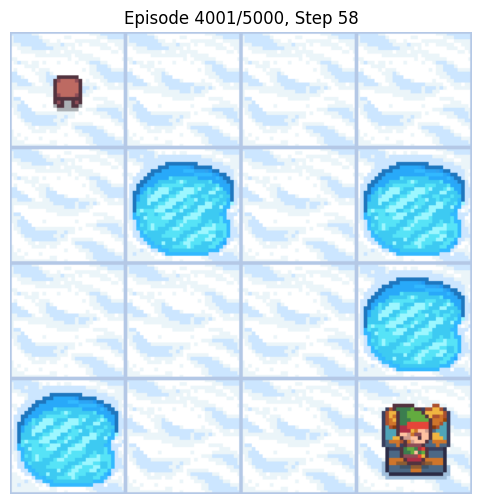

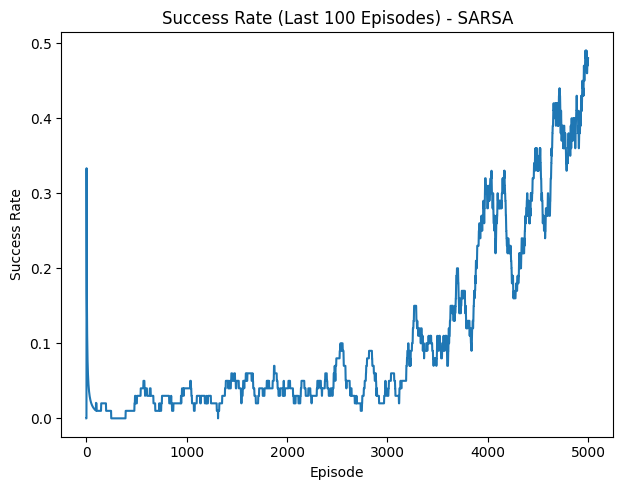

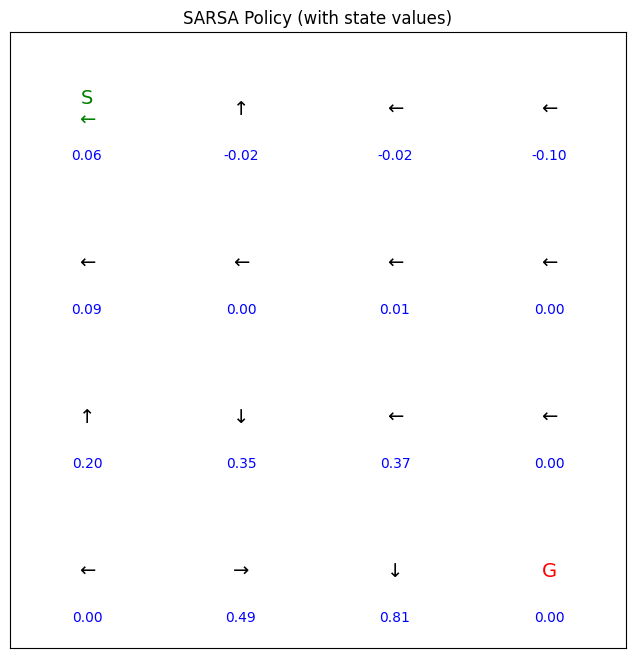


Final Evaluation of trained SARSA policy...
Final success rate over 1000 evaluation episodes: 74.00%


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from IPython.display import display, clear_output

def run_sarsa(episodes, is_training=True, render=True, render_frequency=1000):
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True,
                   render_mode='rgb_array' if render else None)

    if is_training:
        q = np.zeros((env.observation_space.n, env.action_space.n))
    else:
        with open('frozen_lake4x4_sarsa.pkl', 'rb') as f:
            q = pickle.load(f)

    learning_rate_a = 0.1
    discount_factor_g = 0.99
    epsilon = 1.0
    epsilon_decay_rate = 0.9995
    epsilon_min = 0.01
    learning_rate_decay = 0.9999
    min_learning_rate = 0.01

    rng = np.random.default_rng(42)

    rewards_per_episode = np.zeros(episodes)
    cumulative_rewards = []
    success_rates = []

    if render:
        plt.figure(figsize=(6, 6))

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False
        episode_reward = 0
        steps = 0

        if is_training and rng.random() < epsilon:
            action = env.action_space.sample()
        else:
            noise = rng.random(env.action_space.n) * 0.01
            action = np.argmax(q[state, :] + noise)

        while not terminated and not truncated:
            steps += 1
            new_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            if is_training and rng.random() < epsilon:
                new_action = env.action_space.sample()
            else:
                noise = rng.random(env.action_space.n) * 0.01
                new_action = np.argmax(q[new_state, :] + noise)

            if is_training:
                adjusted_reward = reward
                if terminated and reward > 0:
                    adjusted_reward = 1.0
                elif terminated and reward == 0:
                    adjusted_reward = -0.1
                elif not terminated:
                    adjusted_reward = -0.01

                q[state, action] += learning_rate_a * (
                    adjusted_reward + discount_factor_g * q[new_state, new_action] - q[state, action]
                )

            if render and is_training and (i % render_frequency == 0):
                img = env.render()
                plt.clf()
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Episode {i+1}/{episodes}, Step {steps}")
                display(plt.gcf())
                clear_output(wait=True)
                time.sleep(0.1)

            state = new_state
            action = new_action

            if steps > 100:
                truncated = True

        rewards_per_episode[i] = episode_reward

        epsilon = max(epsilon * epsilon_decay_rate, epsilon_min)
        learning_rate_a = max(learning_rate_a * learning_rate_decay, min_learning_rate)

        window = min(100, i+1)
        cumulative_rewards.append(np.mean(rewards_per_episode[max(0, i-window+1):(i+1)]))
        success_rates.append(np.mean(rewards_per_episode[max(0, i-window+1):(i+1)]))

        if is_training and (i+1) % 1000 == 0:
            interim_success = evaluate_policy(q, 1000)
            print(f"\nInterim Evaluation after {i+1} episodes: {interim_success:.2%} success rate\n")

    env.close()

    if is_training:
        with open("frozen_lake4x4_sarsa.pkl", "wb") as f:
            pickle.dump(q, f)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(success_rates)
        plt.title('Success Rate (Last 100 Episodes) - SARSA')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate')
        plt.tight_layout()
        plt.savefig('frozen_lake4x4_sarsa_success_rate.png')
        plt.show()

        visualize_policy(q)

    return q

def evaluate_policy(q, num_episodes=1000):
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)
    total_successes = 0

    for _ in range(num_episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        steps = 0
        while not terminated and not truncated:
            action = np.argmax(q[state, :])
            state, reward, terminated, truncated, _ = env.step(action)
            steps += 1
            if steps > 100:
                truncated = True

        if reward > 0:
            total_successes += 1

    env.close()
    return total_successes / num_episodes

def visualize_policy(q):
    arrows = ['←', '↓', '→', '↑']
    policy = np.argmax(q, axis=1).reshape(4, 4)

    plt.figure(figsize=(8, 8))
    plt.imshow(np.zeros((4, 4)), cmap='gray_r')

    for i in range(4):
        for j in range(4):
            state_idx = i * 4 + j
            action = np.argmax(q[state_idx])
            value = np.max(q[state_idx])
            alpha = min(0.8, max(0.1, value))

            if i == 0 and j == 0:
                plt.text(j, i, 'S\n' + arrows[action], ha='center', va='center',
                         fontsize=14, color='green')
            elif i == 3 and j == 3:
                plt.text(j, i, 'G', ha='center', va='center',
                         fontsize=14, color='red')
            else:
                plt.text(j, i, arrows[action], ha='center', va='center',
                         fontsize=14, color='black')

            plt.text(j, i+0.3, f'{value:.2f}', ha='center', va='center',
                     fontsize=10, color='blue')

    plt.grid(True)
    plt.title('SARSA Policy (with state values)')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('frozen_lake4x4_sarsa_policy.png')
    plt.show()

if __name__ == '__main__':
    print("Training SARSA agent...")
    q = run_sarsa(5000, is_training=True, render=True, render_frequency=1000)

    print("\nFinal Evaluation of trained SARSA policy...")
    success_rate = evaluate_policy(q, 1000)
    print(f"Final success rate over 1000 evaluation episodes: {success_rate:.2%}")

    try:
        with open('frozen_lake4x4.pkl', 'rb') as f:
            q_learning = pickle.load(f)
        q_learning_success = evaluate_policy(q_learning, 1000)
    except:
        pass



Interim Evaluation after 5000 episodes: 72.20% success rate



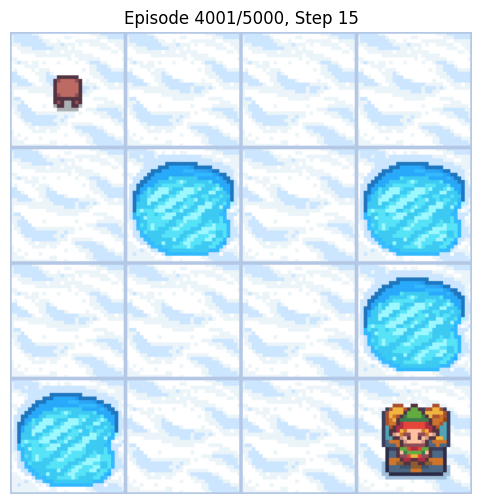

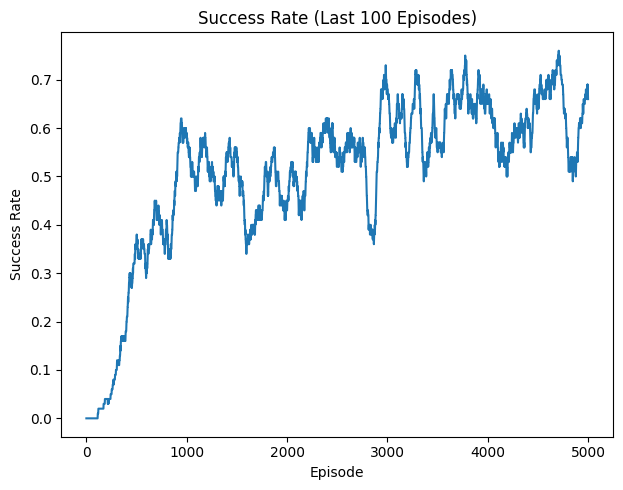

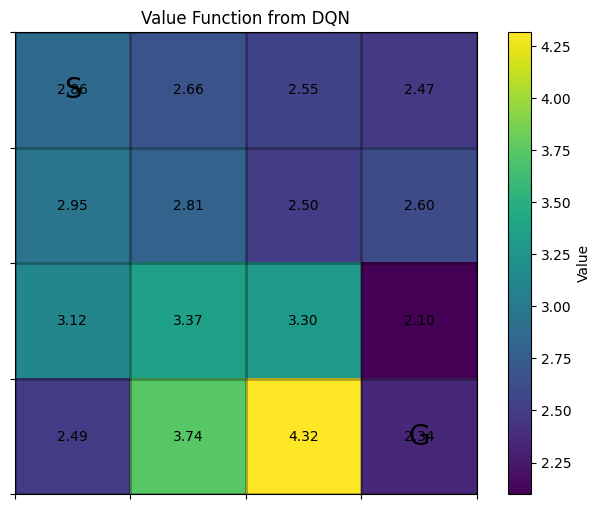


Final Evaluation of trained DQN policy...
Final success rate over 1000 evaluation episodes: 79.00%


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import time
from IPython.display import display, clear_output

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
def state_to_tensor(state, state_size):
    one_hot = np.zeros(state_size)
    one_hot[state] = 1
    return torch.FloatTensor(one_hot).unsqueeze(0)

def run_dqn(episodes, is_training=True, render=True, render_frequency=1000):
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True,
                  render_mode='rgb_array' if render else None)
    state_size = env.observation_space.n
    action_size = env.action_space.n

    policy_net = DQN(state_size, action_size)
    target_net = DQN(state_size, action_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    memory = ReplayMemory(capacity=10000)
    batch_size = 64
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start
    target_update = 10

    rewards_per_episode = np.zeros(episodes)
    success_rates = []
    steps_per_episode = []

    if render:
        plt.figure(figsize=(6, 6))

    for i in range(episodes):
        state = env.reset()[0]
        state_tensor = state_to_tensor(state, state_size)

        terminated = False
        truncated = False
        episode_reward = 0
        steps = 0

        while not terminated and not truncated:
            steps += 1
            if is_training and random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = policy_net(state_tensor).argmax().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state_tensor = state_to_tensor(next_state, state_size)
            episode_reward += reward
            adjusted_reward = reward
            if terminated and reward > 0:
                adjusted_reward = 5.0
            elif terminated and reward == 0:
                adjusted_reward = -1.0
            if is_training:
                memory.push(state_tensor, action, adjusted_reward, next_state_tensor, terminated)
            state = next_state
            state_tensor = next_state_tensor
            if render and is_training and (i % render_frequency == 0):
                img = env.render()
                plt.clf()
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Episode {i+1}/{episodes}, Step {steps}")
                display(plt.gcf())
                clear_output(wait=True)
                time.sleep(0.1)
            if steps > 100:
                truncated = True
            if is_training and len(memory) >= batch_size:
                experiences = memory.sample(batch_size)
                batch = Experience(*zip(*experiences))

                state_batch = torch.cat(batch.state)
                action_batch = torch.tensor(batch.action).unsqueeze(1)
                reward_batch = torch.tensor(batch.reward).unsqueeze(1)

                non_final_mask = torch.tensor([not d for d in batch.done], dtype=torch.bool)
                non_final_next_states = torch.cat([s for s, d in zip(batch.next_state, batch.done) if not d])
                state_action_values = policy_net(state_batch).gather(1, action_batch)

                next_state_values = torch.zeros(batch_size, 1)
                if len(non_final_next_states) > 0:
                    with torch.no_grad():
                        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1, keepdim=True)[0]

                expected_state_action_values = reward_batch + (gamma * next_state_values)

                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_per_episode[i] = episode_reward
        steps_per_episode.append(steps)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if is_training and (i+1) % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        window_size = min(100, i+1)
        success_rates.append(np.mean(rewards_per_episode[max(0, i-window_size+1):(i+1)]))

        if is_training and (i+1) % 1000 == 0:
            interim_success = evaluate_policy_dqn(policy_net, state_size, 1000)
            print(f"\nInterim Evaluation after {i+1} episodes: {interim_success:.2%} success rate\n")

    env.close()

    if is_training:
        torch.save(policy_net.state_dict(), 'frozen_lake_dqn.pth')
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(success_rates)
        plt.title('Success Rate (Last 100 Episodes)')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate')
        plt.tight_layout()
        plt.savefig('frozen_lake_dqn_performance.png')
        plt.show()
        visualize_value_function(policy_net, state_size)

    return policy_net

def evaluate_policy_dqn(policy_net, state_size, num_episodes=1000):
    """Evaluate the DQN policy without exploration"""
    env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)
    total_successes = 0

    for _ in range(num_episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        while not terminated and not truncated:
            state_tensor = state_to_tensor(state, state_size)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax().item()

            state, reward, terminated, truncated, _ = env.step(action)

        if reward > 0:
            total_successes += 1

    env.close()
    return total_successes / num_episodes

def visualize_value_function(policy_net, state_size):
    """Visualize the value function derived from the DQN"""
    values = np.zeros(state_size)

    for state in range(state_size):
        state_tensor = state_to_tensor(state, state_size)
        with torch.no_grad():
            q_values = policy_net(state_tensor).numpy()[0]
            values[state] = np.max(q_values)
    v_grid = values.reshape(4, 4)
    plt.figure(figsize=(8, 6))
    plt.imshow(v_grid, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title('Value Function from DQN')
    for i in range(4):
        for j in range(4):
            plt.text(j, i, f'{v_grid[i, j]:.2f}',
                    ha='center', va='center', color='white' if v_grid[i, j] < 0.5 else 'black')
    plt.grid(which='major', color='black', linestyle='-', linewidth=2, alpha=0.3)
    plt.xticks(np.arange(-.5, 4, 1), [])
    plt.yticks(np.arange(-.5, 4, 1), [])
    plt.text(0, 0, 'S', fontsize=20, ha='center', va='center', color='black')
    plt.text(3, 3, 'G', fontsize=20, ha='center', va='center', color='black')

    plt.savefig('frozen_lake_dqn_value_function.png')
    plt.show()

if __name__ == '__main__':
    print("Training DQN agent...")
    policy_net = run_dqn(5000, is_training=True, render=True, render_frequency=1000)

    print("\nFinal Evaluation of trained DQN policy...")
    success_rate = evaluate_policy_dqn(policy_net, 16, 1000)  # 16 states in 4x4 grid
    print(f"Final success rate over 1000 evaluation episodes: {success_rate:.2%}")